# Car accident

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import datetime
import os
from tueplots import bundles
from tueplots.constants.color import rgb
import sklearn as sk
from sklearn.decomposition import PCA
import seaborn as sns

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

if not os.path.exists('Graphen'):
    os.mkdir('Graphen')
if not os.path.exists('Daten'):
    os.mkdir('Daten')

In [2]:
try:
    accidents = pd.read_csv('FARS2021NationalCSV/accident.csv',encoding='WINDOWS-1252')
except:
    with open('FARS2021NationalCSV/accident.csv', 'rb') as f:
        result = chardet.detect(f.read())  # or readline if the file is large
    accidents = pd.read_csv('FARS2021NationalCSV/accident.csv',encoding=result)
    print(result)
accidents['date'] = pd.to_datetime(accidents[['YEAR','MONTH','DAY']])


try:
    people = pd.read_csv('Daten/people.csv',index_col=0)
except:
    people = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv',encoding='ISO-8859-10')
    people.to_csv('Daten/people.csv')
    
try:
    Google_daten = pd.read_csv('Daten/Google_daten(US).csv',parse_dates=['date'],index_col=0)
except:
    Google_daten = pd.read_csv('https://storage.googleapis.com/covid19-open-data/v2/main.csv',skiprows=range(1,14096993),nrows=2368485,parse_dates=['date'])
    Google_daten.sort_values(by=['subregion1_name','date'])
    Google_daten.to_csv('Daten/Google_daten(US).csv')



#remove unnecessary data
Google_daten = Google_daten[save_Google['date']>'2021'] #no data from years before 2021 is needed
Google_daten = Google_daten.groupby(by=['subregion1_name','date']).first().reset_index()    # delete countys


print(people[people['CTYNAME'].isin(people['STNAME'])][['STATE','CTYNAME','POPESTIMATE2021']].groupby('STATE').first())
print(accidents.columns)
print(accidents)

save_Google = Google_daten.copy()

/tmp/ipykernel_3610/3790101261.py:18: DtypeWarning: Columns (12,13,103) have mixed types. Specify dtype option on import or set low_memory=False.
  Google_daten = pd.read_csv('Daten/Google_daten(US).csv',parse_dates=['date'],index_col=0)


                    CTYNAME  POPESTIMATE2021
STATE                                       
1                   Alabama          5039877
2                    Alaska           732673
4                   Arizona          7276316
5                  Arkansas          3025891
6                California         39237836
8                  Colorado          5812069
9               Connecticut          3605597
10                 Delaware          1003384
11     District of Columbia           670050
12                  Florida         21781128
13                  Georgia         10799566
15                   Hawaii          1441553
16                    Idaho          1900923
17                 Illinois         12671469
18                  Indiana          6805985
19                     Iowa          3193079
20                   Kansas          2934582
21                 Kentucky          4509394
22                Louisiana          4624047
23                    Maine          1372247
24        

In [46]:
Google_daten = save_Google.copy()
#print(Google_daten)
Google_daten['STATENAME'] = Google_daten['subregion1_name']
Google_daten = Google_daten.groupby(by=['subregion1_name','date']).first().reset_index()
Google_daten = Google_daten.sort_values(by=['subregion1_name','date'])
temp = accidents
#print(temp['subregion1_name'].unique())
#print(Google_daten['subregion1_name'].unique())
temp['subregion1_name'] = temp['STATENAME']
temp = temp.groupby(['subregion1_name','date']).size().reset_index(name='cases')
Google_daten = pd.merge(Google_daten,temp, on=['subregion1_name','date'],how='left')
Google_daten = Google_daten.fillna(0)
print(Google_daten.columns)
Google_daten['population_density'] = Google_daten['population']/Google_daten['area']
weather_stat = ['rainy_day','snowy_day','low_temp_av','low_temp_min','low_temp_max','around_4_degree']
Google_daten[weather_stat] = 0
Google_daten.loc[Google_daten['rainfall']>0,'rainy_day'] = 1
t_criticcal = 4
Google_daten.loc[Google_daten['average_temperature']<t_criticcal,'low_temp_av'] = 1
Google_daten.loc[Google_daten['minimum_temperature']<t_criticcal,'low_temp_min'] = 1
Google_daten.loc[Google_daten['maximum_temperature']<t_criticcal,'low_temp_max'] = 1
Google_daten.loc[Google_daten['low_temp_max']+Google_daten['low_temp_min'] == 1,'around_4_degree'] = 1
Google_daten.loc[Google_daten['snowfall']>0,'snowy_day'] = 1

print(Google_daten[['rainfall','rainy_day']])

#print(Google_daten[['subregion1_name','date','cases']])


accidents_state = accidents.value_counts('STATENAME',sort=False).to_frame().reset_index()
accidents_state['CASES'] = accidents_state['count']
del accidents_state['count']



#accidents_state['STATENAME'] = accidents['STATENAME'].unique()
accidents_state['Population'] = Google_daten.groupby('subregion1_name').first()['population'][accidents['STATENAME'].unique()].to_numpy()
#merge population
temp = Google_daten[Google_daten['date']>'2021'].groupby('STATENAME').first().loc[:,'population_age_00_09':'population_age_80_and_older'].reset_index()
accidents_state = pd.merge(accidents_state.reset_index(),temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])
# merge rainy/snowy days
temp = Google_daten[Google_daten['date']>'2021'][['STATENAME']+weather_stat].groupby('STATENAME').sum().loc[:,'rainy_day':'around_4_degree'].reset_index()
accidents_state = pd.merge(accidents_state.reset_index(),temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])
print(accidents_state)
# cases on certain weather:
for i in accidents['WEATHERNAME'].unique():
    temp = accidents[accidents['WEATHERNAME'] == i].value_counts('STATENAME',sort=False).to_frame().reset_index()
    temp['CASES_'+i] = temp['count']
    del temp['count']
    accidents_state = pd.merge(accidents_state,temp,on=['STATENAME'],how='left')
    accidents_state['CASES_'+i] = accidents_state['CASES_'+i].fillna(0)


print(accidents_state.head())
print(Google_daten[Google_daten['date']>'2021'].groupby('STATENAME').first().loc[:,'population_age_00_09':'population_age_80_and_older'])

accidents_state['POPULATION_2021'] = people[people['CTYNAME'].isin(people['STNAME'])].groupby('STATE').first()['POPESTIMATE2021']
accidents_state['CASES_NORM'] = accidents_state['CASES']/accidents_state['Population']
accidents_state['CASES/100000'] = accidents_state['CASES_NORM']*100000


Google_daten['CASES/100000'] = Google_daten['cases']/Google_daten['population']*100000

print(accidents_state)

Index(['subregion1_name', 'date', 'key', 'place_id', 'wikidata', 'datacommons',
       'country_code', 'country_name', 'subregion1_code', 'subregion2_code',
       ...
       'noaa_distance', 'average_temperature', 'minimum_temperature',
       'maximum_temperature', 'rainfall', 'snowfall', 'dew_point',
       'relative_humidity', 'STATENAME', 'cases'],
      dtype='object', length=113)
       rainfall  rainy_day
0        9.5758          1
1        0.0000          0
2        0.0000          0
3        0.0000          0
4        0.0000          0
...         ...        ...
19819    0.0000          0
19820    0.0000          0
19821    0.0000          0
19822    0.0000          0
19823    0.0000          0

[19824 rows x 2 columns]
    level_0  index             STATENAME  CASES  Population  \
0         0      0               Alabama    885     4858979   
1         1      1                Alaska     59      738432   
2         2      2               Arizona   1063     6828065   
3       

## Correlation

    level_0  index             STATENAME  CASES  Population  \
0         0      0               Alabama    885     4858979   
1         1      1                Alaska     59      738432   
2         2      2               Arizona   1063     6828065   
3         3      3              Arkansas    631     2978204   
4         4      4            California   3983    39144818   
5         5      5              Colorado    638     5456574   
6         6      6           Connecticut    283     3590886   
7         7      7              Delaware    132      945934   
8         8      8  District of Columbia     40      705749   
9         9      9               Florida   3451    20271272   
10       10     10               Georgia   1670    10214860   
11       11     11                Hawaii     94     1431603   
12       12     12                 Idaho    244     1654930   
13       13     13              Illinois   1210    12859995   
14       14     14               Indiana    863     661

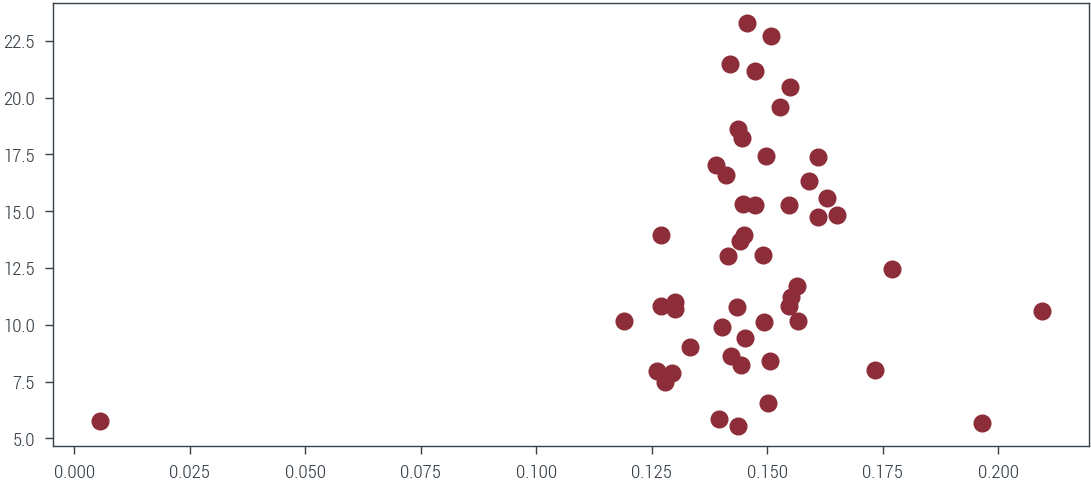

/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1102.36x496.063 with 0 Axes>

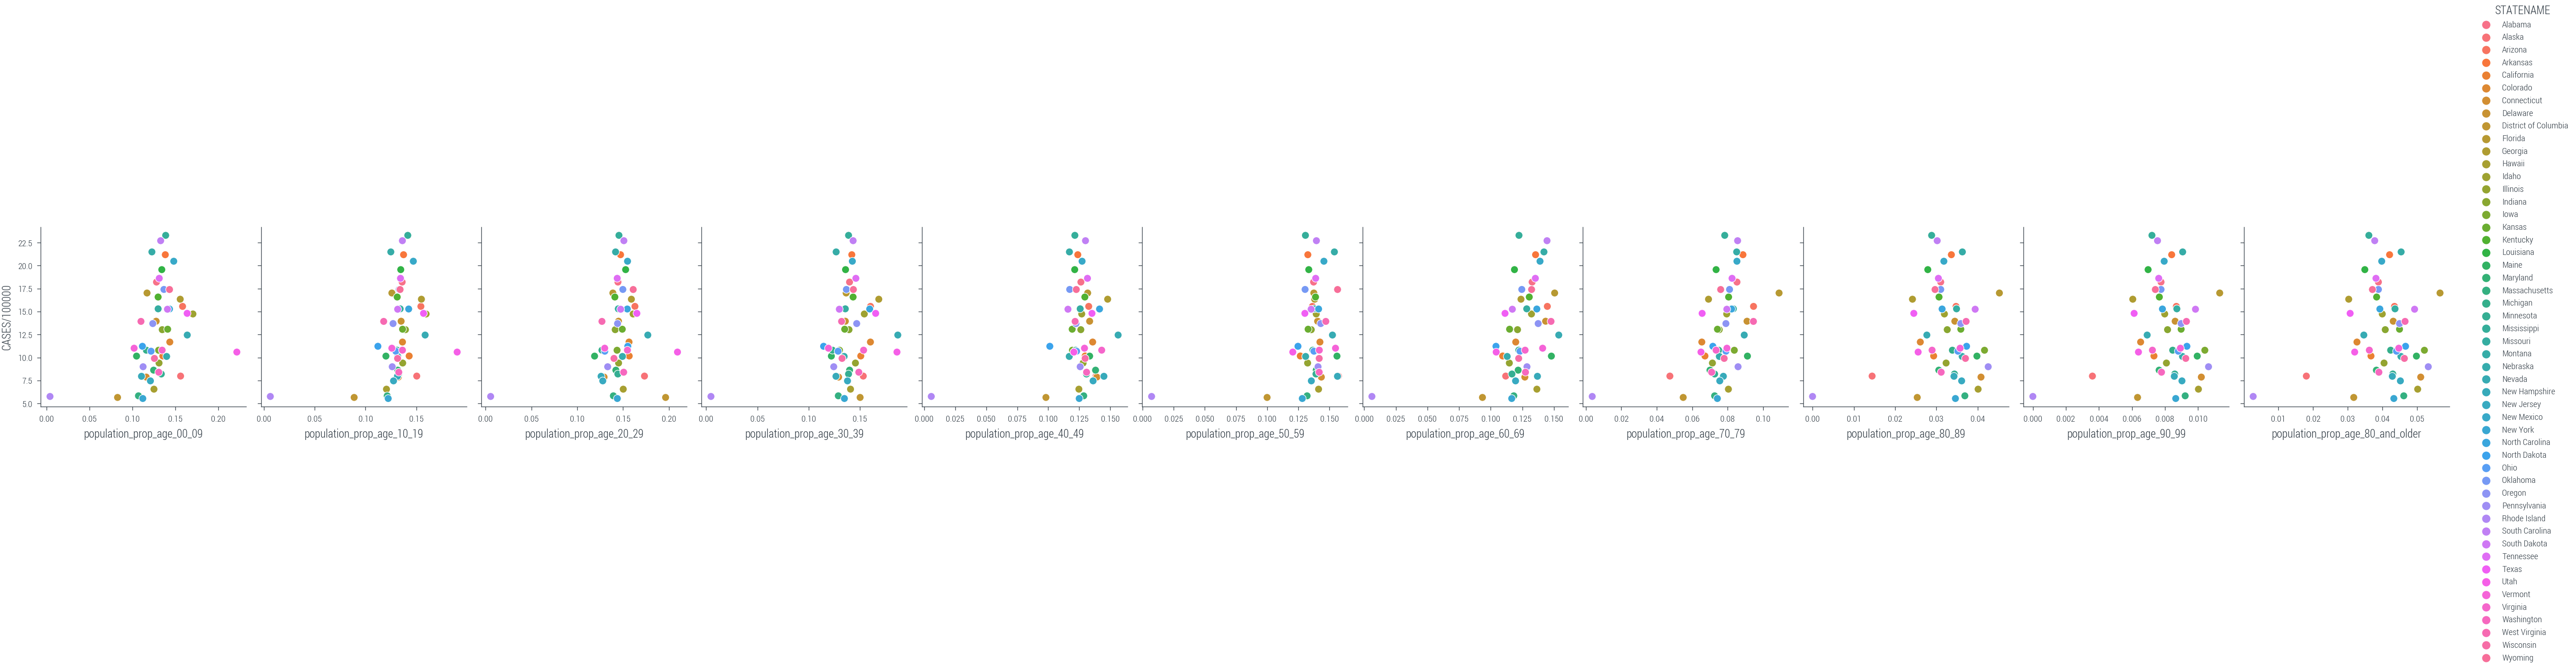

/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1102.36x496.063 with 0 Axes>

/home/jonathan/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


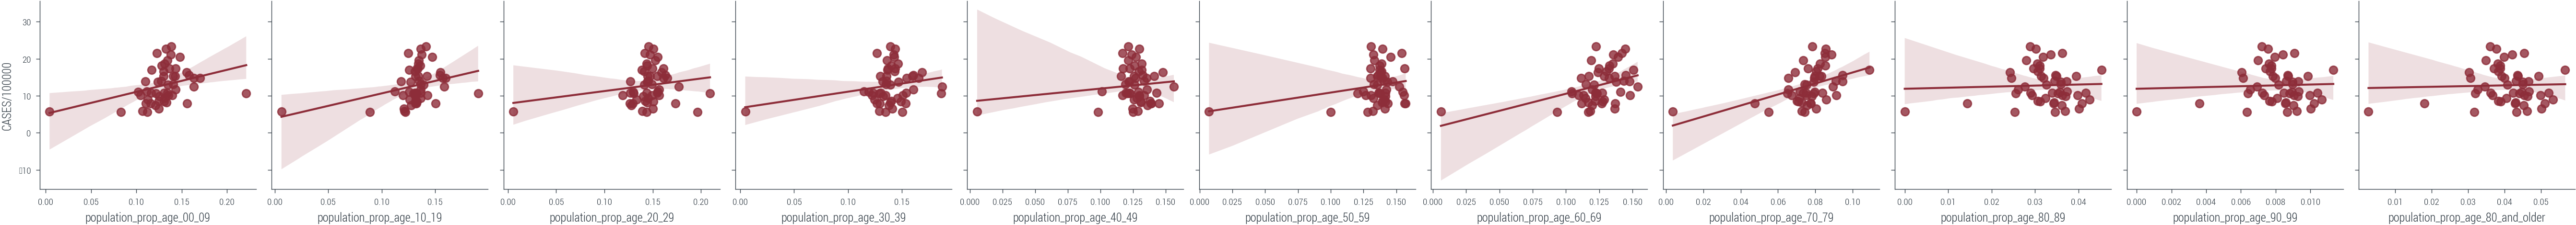

/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1102.36x496.063 with 0 Axes>

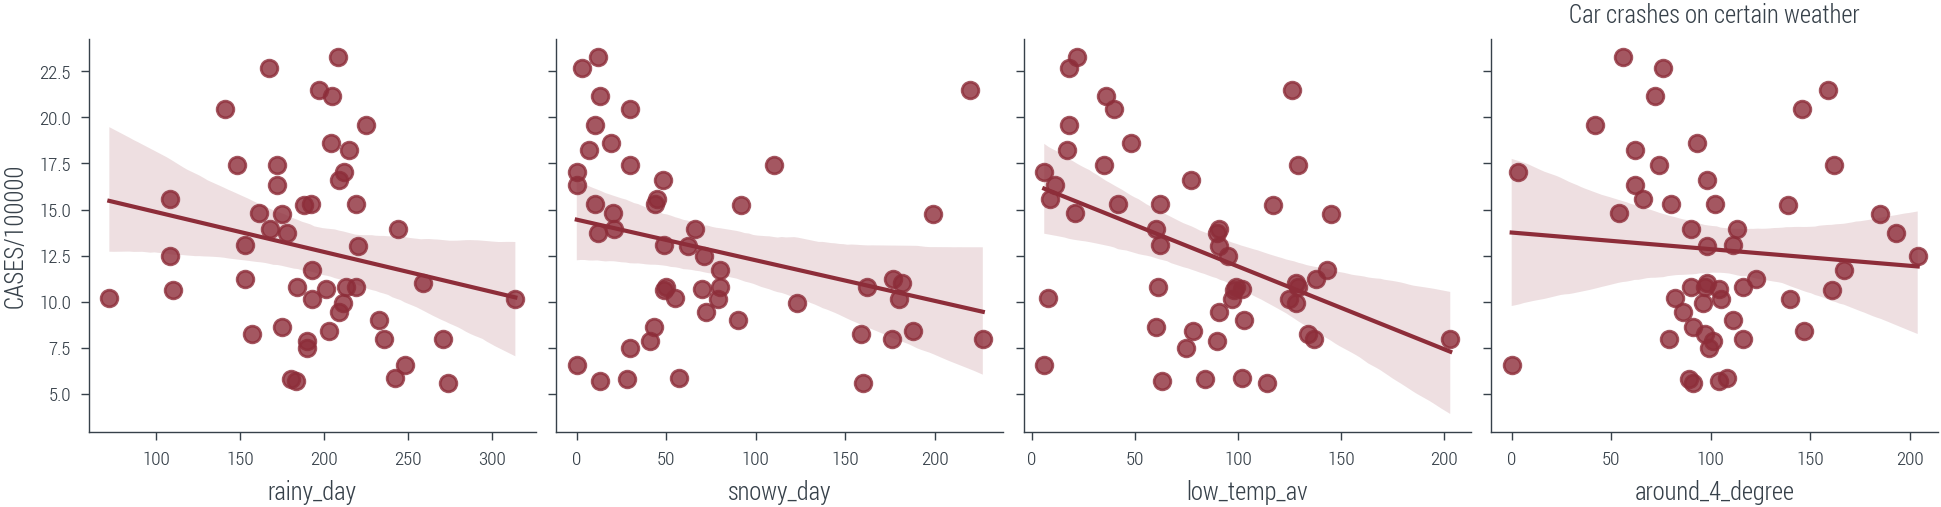

(51, 11)
(1, 51)
[[1.         0.99787333 0.99555522 0.99727237 0.99009489 0.98388354
  0.96838696 0.94506262 0.92471826 0.92471778 0.92471551 0.93895222]
 [0.99787333 1.         0.99867678 0.99902209 0.99600694 0.99193265
  0.97824633 0.95770642 0.94299196 0.94299153 0.94299295 0.93347367]
 [0.99555522 0.99867678 1.         0.99912622 0.99638474 0.99220566
  0.97946069 0.95973141 0.94651853 0.94651812 0.9465203  0.92692345]
 [0.99727237 0.99902209 0.99912622 1.         0.9967161  0.99175739
  0.97923293 0.95847067 0.94252286 0.94252243 0.94252429 0.9329825 ]
 [0.99009489 0.99600694 0.99638474 0.9967161  1.         0.99829025
  0.98999094 0.97378675 0.96323002 0.96322966 0.96322957 0.92921687]
 [0.98388354 0.99193265 0.99220566 0.99175739 0.99829025 1.
  0.99420329 0.98105591 0.97387523 0.9738749  0.9738678  0.9265806 ]
 [0.96838696 0.97824633 0.97946069 0.97923293 0.98999094 0.99420329
  1.         0.99539331 0.98595122 0.98595102 0.98594308 0.93847899]
 [0.94506262 0.95770642 0.959731

In [47]:
population_names = ['population_prop_age_00_09','population_prop_age_10_19','population_prop_age_20_29','population_prop_age_30_39','population_prop_age_40_49','population_prop_age_50_59','population_prop_age_60_69','population_prop_age_70_79','population_prop_age_80_89','population_prop_age_90_99','population_prop_age_80_and_older']
accidents_state[population_names] = 0
#print(accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].sum(axis=0))
accidents_state.loc[:,'population_prop_age_00_09':'population_prop_age_80_and_older'] = accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy()/accidents_state['Population'].to_numpy().reshape(-1,1)

#print(accidents_state.loc[:,'population_prop_age_00_09':'population_prop_age_90_99'].sum(axis=1).max())
print(accidents_state)
#accidents_state.loc[:,'population_prop_age_00_09':'population_prop_age_80_and_older'] = accidents_state.loc[:,'population_prop_age_00_09':'population_prop_age_80_and_older'].div(accidents_state['Population'])


print(accidents_state)

plt.figure()
plt.scatter(accidents_state['population_prop_age_20_29'],accidents_state['CASES/100000'])
plt.show()

plt.figure()
sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=population_names,hue='STATENAME')
plt.show()

plt.figure()
sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=population_names,kind='reg')#,hue='STATENAME'
plt.show()

plt.figure()
sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=['rainy_day','snowy_day','low_temp_av','around_4_degree'],kind='reg')
plt.title('Car crashes on certain weather')
plt.show()


print(accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy().shape)
print(accidents_state.loc[:,'CASES/100000'].to_numpy().reshape((1,-1)).shape)
corr = np.corrcoef(accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy().T,accidents_state.loc[:,'CASES'].to_numpy().reshape((1,-1)))
print(corr)





## List cases

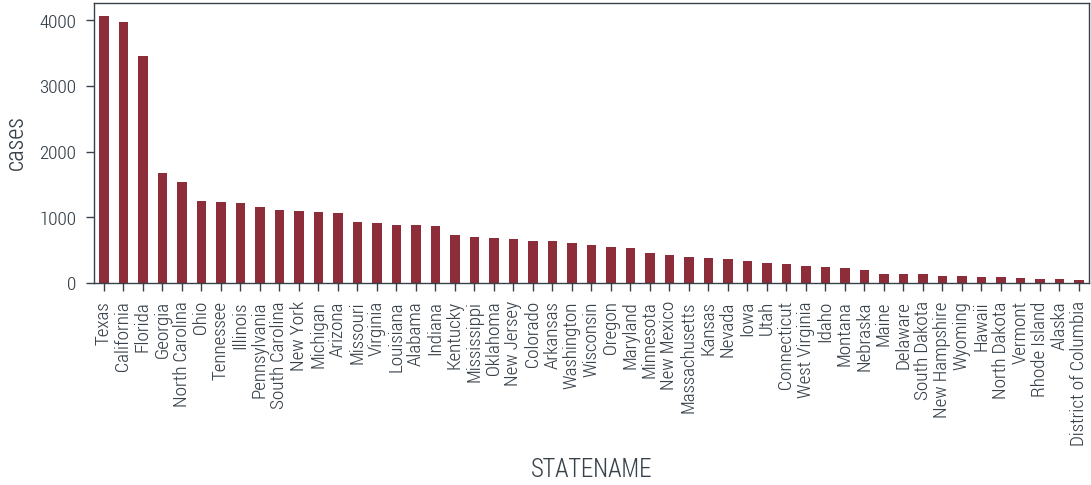

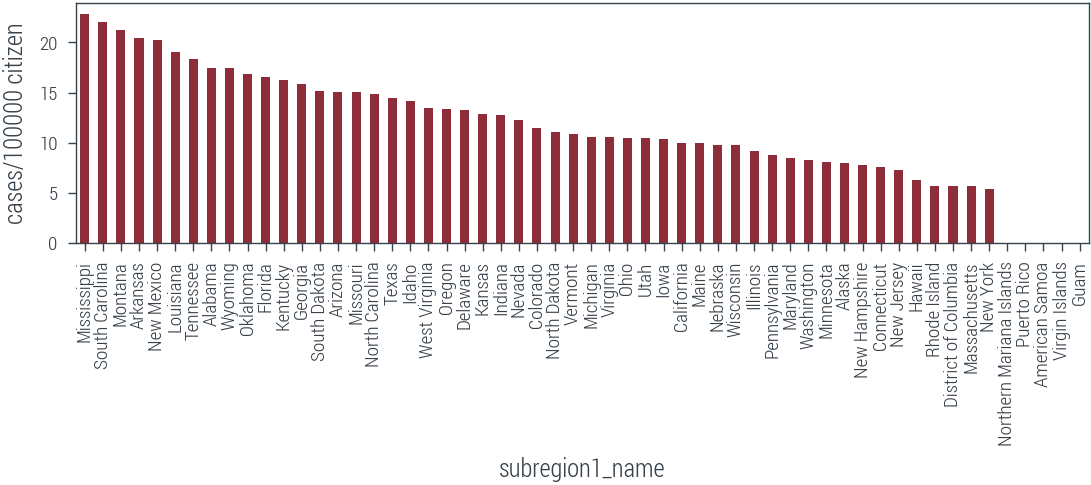

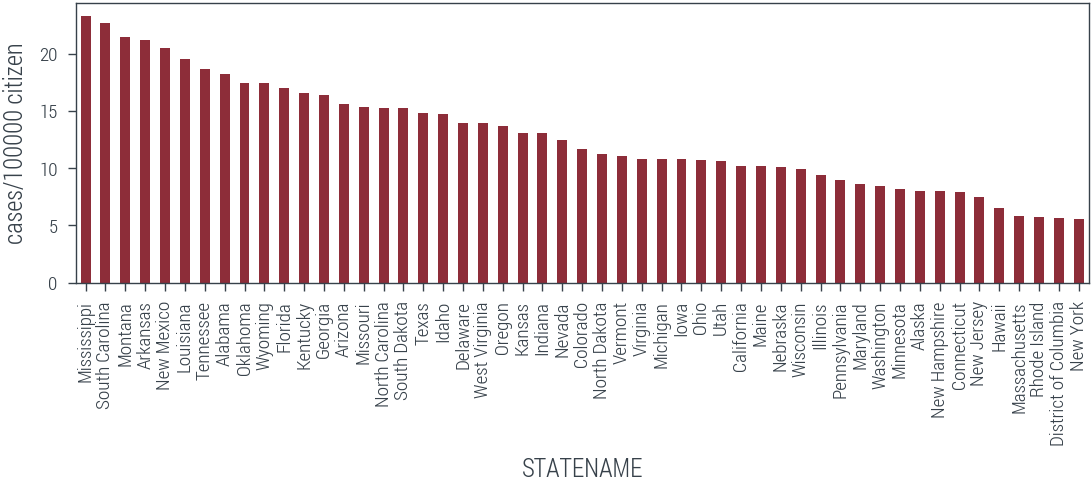

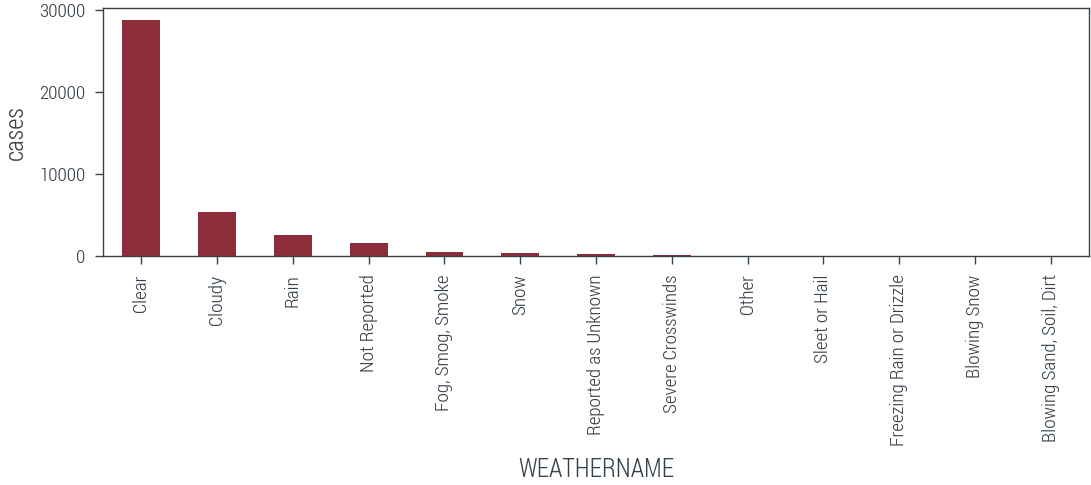

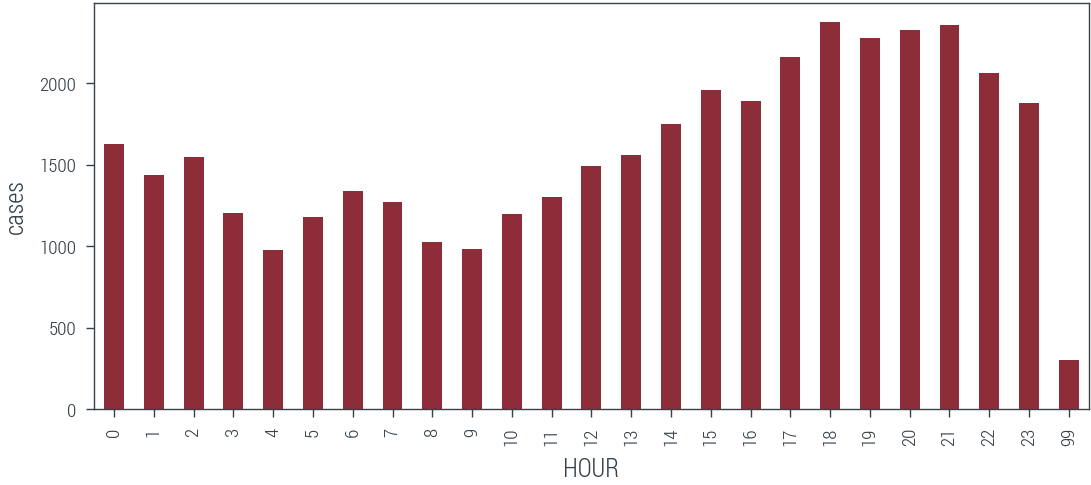

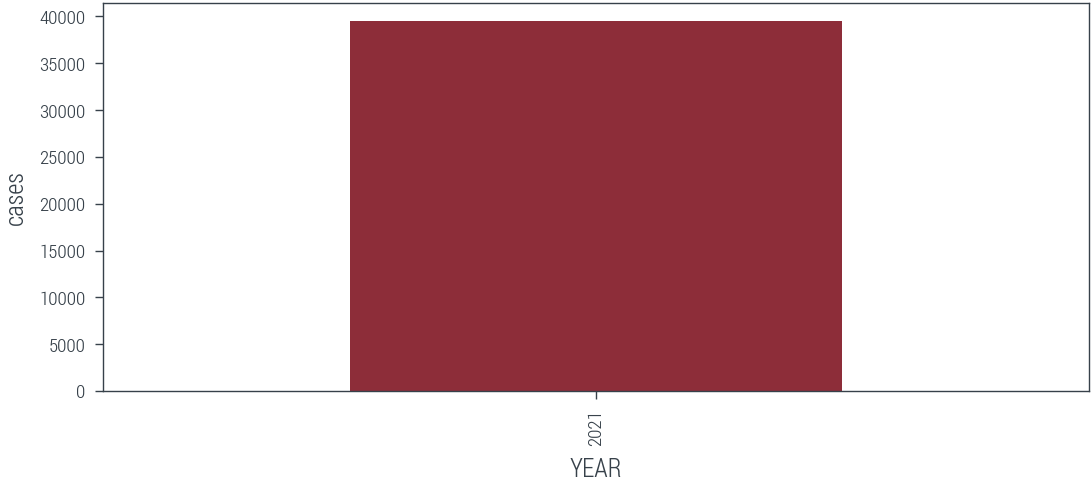

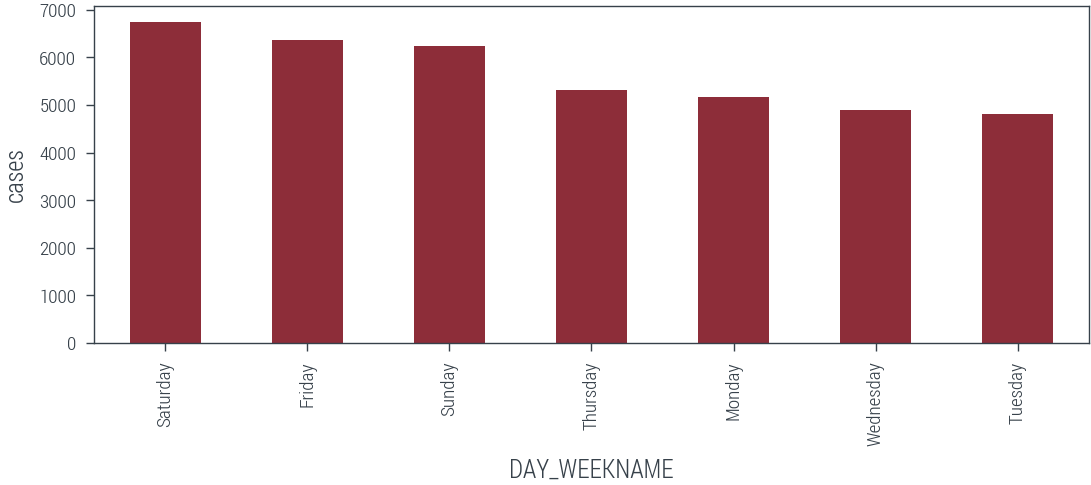

<Figure size 1102.36x496.063 with 0 Axes>

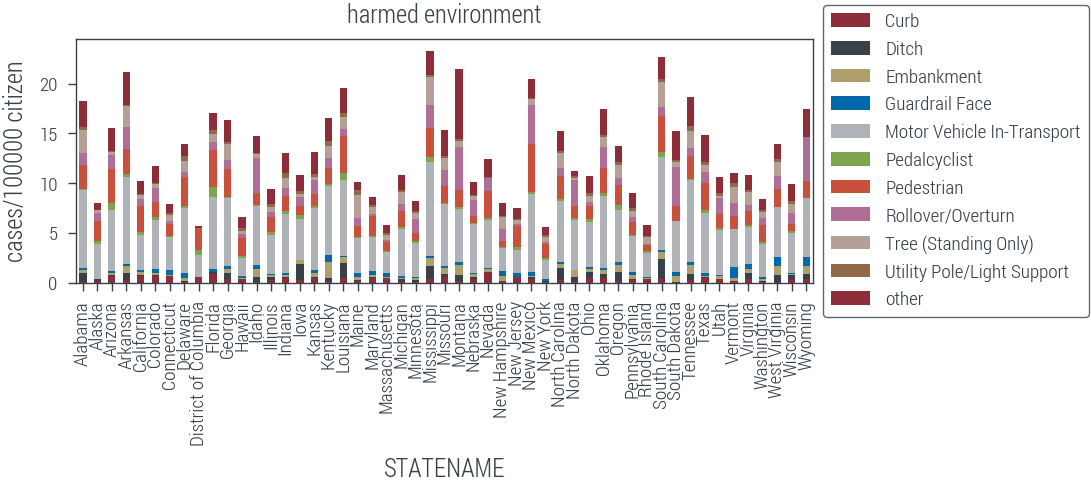

In [21]:


plt.figure()
accidents['STATENAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()

Google_daten.groupby('subregion1_name')['CASES/100000'].sum().sort_values(ascending=False).plot(kind='bar')
#Google_daten.groupby('subregion1_name')['mobility_workspaces'].first().plot(kind='bar')
plt.ylabel('cases/100000 citizen')
plt.show()


plt.figure()
#plt.title('cases per 100000 habitants')
accidents_state.set_index('STATENAME')['CASES/100000'].sort_values(ascending=False).plot.bar()
plt.ylabel('cases/100000 citizen')
plt.show()

plt.figure()
accidents['WEATHERNAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['HOUR'].value_counts().sort_index().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['YEAR'].value_counts().sort_index().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['DAY_WEEKNAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()


accidents['HARM_EVNAME'] = accidents['HARM_EVNAME'].replace(accidents['HARM_EVNAME'].value_counts().index[10:],'other')

plt.figure()
accidents.groupby(['STATENAME','HARM_EVNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['Population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
plt.title('harmed environment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()